<center><h1>Song Genre Prediction</h1><center>
<img src="image/microphone.jpg" alt="microphone">

В този notebook ще се опитаме да тренираме модел, който познава жанра на песен по текста й. 
Dataset-ът се намира тук: 
https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics 

In [103]:
# import necessary libraries
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

Нека заредим и разгледаме данните. Данните бяха предварително трансформирани в preprocessing notebook-а.


Тук ще записваме резултатите.

In [54]:
result = {}

In [55]:
# Dataset
dataset = pd.read_csv("reduced.csv")
print(dataset.shape)
dataset.info()
dataset.head()

(192165, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192165 entries, 0 to 192164
Data columns (total 3 columns):
Unnamed: 0    192165 non-null int64
genre         192165 non-null object
lyrics        192165 non-null object
dtypes: int64(1), object(2)
memory usage: 4.4+ MB


,Unnamed: 0,genre,lyrics
0,0,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,1,Pop,"playin' everything so easy, it's like you seem..."
2,2,Pop,If you search For tenderness It isn't hard to ...
3,3,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,4,Pop,"Party the people, the people the party it's po..."


Директно премахвам песните от жанр Rock, защото са много голяма част от песните и броят им ще повлияе на модела. Другото, което може да се направи е да се съкратят на 1/4 примерно, но данните са много и тренирането отнема много време, затова за сега оставям първата възможност.

In [56]:
dataset = dataset[~dataset.genre.str.contains("Rock")]
dataset = dataset.drop("Unnamed: 0", axis=1)
print(dataset.shape)

(104639, 2)


In [57]:
genres = dataset.genre.unique()
print(genres)

['Pop' 'Hip-Hop' 'Metal' 'Other' 'Country' 'Jazz' 'Electronic' 'Folk'
 'R&B' 'Indie']


In [58]:
y = dataset["genre"]
X = dataset[dataset.columns.difference(['genre'])]
y = pd.DataFrame(y)
print(X.shape)
print(y.shape)

(104639, 1)
(104639, 1)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(70108, 1)
(34531, 1)
(70108, 1)
(34531, 1)


<h1>EDA (Exploratory data analysis):</h1>

Нека разгледаме данните, тренираме базов модел и да добавим нови feature-и.

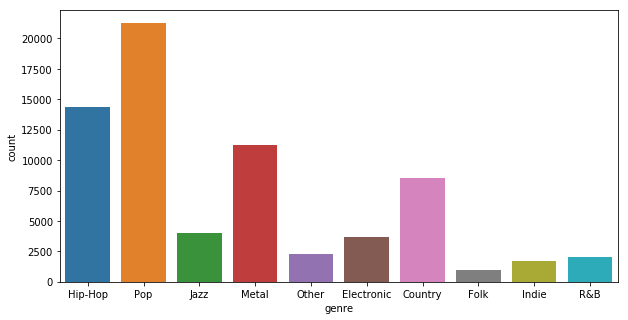

In [60]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.countplot(data=y_train, x="genre")

In [61]:
genres_values = y_train.genre.value_counts()
genres = list(genres_values.index)
print(genres_values)
print(genres)

Pop           21278
Hip-Hop       14386
Metal         11233
Country        8549
Jazz           4026
Electronic     3668
Other          2258
R&B            2000
Indie          1739
Folk            971
Name: genre, dtype: int64
['Pop', 'Hip-Hop', 'Metal', 'Country', 'Jazz', 'Electronic', 'Other', 'R&B', 'Indie', 'Folk']


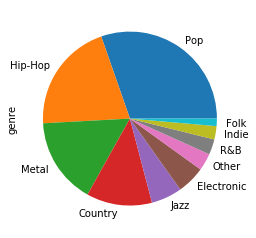

In [62]:
genres_values.plot.pie()

Нека направим topic modeling на целия на корпус и на всеки жанр използвайки LatentDirichletAllocation.

In [32]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [37]:
def try_lda(data):
    train, test = train_test_split(data, test_size=0.33, random_state=42)
    words = list(train.lyrics.values)
    
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95,
                                         min_df=2,
                                         stop_words='english',
                                         decode_error='ignore')

    tf = tf_vectorizer.fit_transform(words)

    lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)

    lda.fit(tf)
    topics = lda.components_
    n_top_words = 20
    print("\nTopics in LDA model: ")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    return topics

In [38]:
corpus_topics = try_lda(dataset)


Topics in LDA model: 

Topic #0:don know baby just let want got ll girl like make gonna come wanna time right cause feel way oh

Topic #1:old man big little said new like white city town daddy woman boy kid house black young gimme red car

Topic #2:life time ll world eye come god day away light ve soul like die mind hand dream way end live

Topic #3:like nigga got ain shit don know bitch fuck ya cause em money yo just man make as hit yeah

Topic #4:shake beat boom bye king funky let drop funk bass ye dah boogie mary drum london follow go jungle sound

Topic #5:night na day song like ll blue star sun sing sweet dream sky come home rain love light christmas moon

Topic #6:oh yeah la hey ooh da ya uh baby like ha huh yea ba ay girl boy party woah lady

Topic #7:love know don just heart say ve thing time way need cause away feel tell think life believe like said

Topic #8:man ah dem dance mi di doo nah bad yuh fi gal jump step come dat nuh yes pum say

Topic #9:blood death dead body war f

In [35]:
def try_lda_genre(data):
    train, test = train_test_split(data, test_size=0.33, random_state=42)
    genres = list(train.genre.unique())
    
    results = []
    for genre in genres:
        genre_words = list(train[train.genre.str.contains(genre)].lyrics.values)
        tf_vectorizer = LemmaCountVectorizer(max_df=0.95,
                                             min_df=2,
                                             stop_words='english',
                                             decode_error='ignore')

        tf = tf_vectorizer.fit_transform(genre_words)

        lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                        learning_method = 'online',
                                        learning_offset = 50.,
                                        random_state = 0)
        lda.fit(tf)
        topics = lda.components_
        n_top_words = 10
        tf_feature_names = tf_vectorizer.get_feature_names()
        print(genre)
        print_top_words(lda, tf_feature_names, n_top_words)
        results.append((genre, topics))
    
    return results

In [36]:
genre_topics = try_lda_genre(dataset)

Hip-Hop

Topic #0:like rhyme people ll cause rap black time man word

Topic #1:white tee movin bet rockin cassidy ole ahhh pink walkin

Topic #2:nigga shit don fuck ain ya em got cause like

Topic #3:know love don just baby girl oh let like time

Topic #4:like got nigga know bitch don ain money shit yeah

Topic #5:fucking hi closet eminem co fuck ninja rule rat ja

Topic #6:uh huh low dirty bag throw yup chick mon rollin

Topic #7:bounce gimmie erick sermon yall biggie squad champion kush ayy

Topic #8:da dem mi di na man yuh dat ah nah

Topic #9:shake ay drop girl booty dance clap as rain floor
Pop

Topic #0:man im woman dont step coming mother ill war thats

Topic #1:look big head like kiss doo said did saw blue

Topic #2:let come like night tonight light feel dance turn free

Topic #3:day world life ll dream home new time song christmas

Topic #4:love know don ll just time ve heart say feel

Topic #5:oh yeah baby ooh ah love whoa uh yes alright

Topic #6:got don know girl like baby 

Folk

Topic #0:dear wi lang auld god aye ye oh shall weaver

Topic #1:away sea sail old love ll come sweet like land

Topic #2:gather okay loved em sittin bay dock divide dreamt combine

Topic #3:canada beaver guy burned john manly bop want hey war

Topic #4:love know ll oh like time don ve just day

Topic #5:gold lift broke santa weight pulling anxious ho barrel like

Topic #6:la sing christmas come men angel eye ye king night

Topic #7:old blow wind whack weather lay loora toora blessing ll

Topic #8:shule daddy fall dumb wack goin da jar creek whiskey

Topic #9:low yeah na man wanna butter sandwich love oh war
Indie

Topic #0:josephine kick click disappeared runaway feared scene high scrap five

Topic #1:alright day honey lesbian dog cure posing fashion aid roll

Topic #2:shine child human little darlin beach dead dance vital chinese

Topic #3:head boom lyric da ready outta oh dont bomb bret

Topic #4:im outta emo falling somethings apart realize dont wasted mile

Topic #5:know don 

<h1>Baseline Model:</h1>

In [63]:
def check_prediction(pipeline, X_test, y_test):
    predicted = pipeline.predict(X_test.lyrics)
    print("Success rate: " + str(np.mean(predicted == y_test.genre)))
    return predicted

In [64]:
def check_vectorizer(pipeline):
    count_vectorizer = pipeline.steps[0][1]
    print(count_vectorizer)
    return count_vectorizer

In [65]:
def get_prediction(pipeline, X_train, y_train):
    prediction = cross_val_predict(pipeline, X_train, y_train, cv=3, n_jobs=-1)
    return prediction

In [66]:
def plot_confusion_matrix(data, predicted, genres):
    fig = plt.gcf()
    fig.set_size_inches(16, 18)
    mat = confusion_matrix(data, predicted)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=genres,yticklabels=genres)
    
    plt.xlabel('true label')
    plt.ylabel('predicted label')

1. Recall е способноста на класификатора да намира позитивни резултати. Тоест да класифицира поп песни като поп песни.<br>
2. Precision е способноста на класификатора да не обърква негативен резултат като позитивен. Тоест да класифицира метъл песен като хип-хоп песен.<br>
3. F-score е средното от precision и recall. <br>
4. support е броя срещания на всеки клас във вярното множество.

In [67]:
def get_stats(pipeline, X_train, X_test, y_train, y_test, genres):
    check_prediction(pipeline, X_test, y_test)
    count_vectorizer = check_vectorizer(pipeline)
   
    print(list(count_vectorizer.vocabulary_.items())[:15])

    prediction = cross_val_predict(pipeline, X_train.lyrics, y_train.genre, cv=3, n_jobs=-1)
    plot_confusion_matrix(y_train.genre, prediction, genres)
    
    precision, recall, fscore, support = precision_recall_fscore_support(y_train.genre, prediction)

    for n, genre in enumerate(genres):
        print(str(genre) + ' recall: {}'.format(recall[n]))
        print(str(genre) + ' precision: {}'.format(precision[n]))
        print(str(genre) + ' fscore: {}'.format(fscore[n]))
        print(str(genre) + ' support: {}'.format(support[n]))
        print()

In [68]:
def try_LSVC():
    pipeline = Pipeline(
    [('features', CountVectorizer()),
     ('clf', LinearSVC())])

    prediction = cross_val_score(pipeline, X_train.lyrics, y_train.genre, cv=3, n_jobs=-1)
    pipeline.fit(X_train.lyrics, y_train.genre)
    
    print(prediction)
    
    return pipeline, prediction

pipeline, prediction = try_LSVC()
result["linear_svc"] = prediction

[0.54729816 0.53164178 0.547937  ]


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Success rate: 0.567229446005039
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[('verse', 109103), ('gun', 44957), ('shots', 91008), ('she', 90290), ('like', 59117), ('the', 101635), ('realest', 82067), ('shit', 90707), ('ever', 35066), ('wrote', 113759), ('drug', 31337), ('addiction', 2249), ('for', 39296), ('my', 67677), ('pain', 73400)]
Pop recall: 0.5670838694584162
Pop precision: 0.5028002489110143
Pop fscore: 0.5330108295310868
Pop support: 8549

Hip-Hop recall: 0.20119956379498363
Hip-Hop precision: 0.22323049001814882
Hip-Hop fscore: 0.2116432463435618
Hip-Hop support: 3668

Metal recall: 0.121524201853759
Metal precision: 0.14407814407814407
Metal fscore:

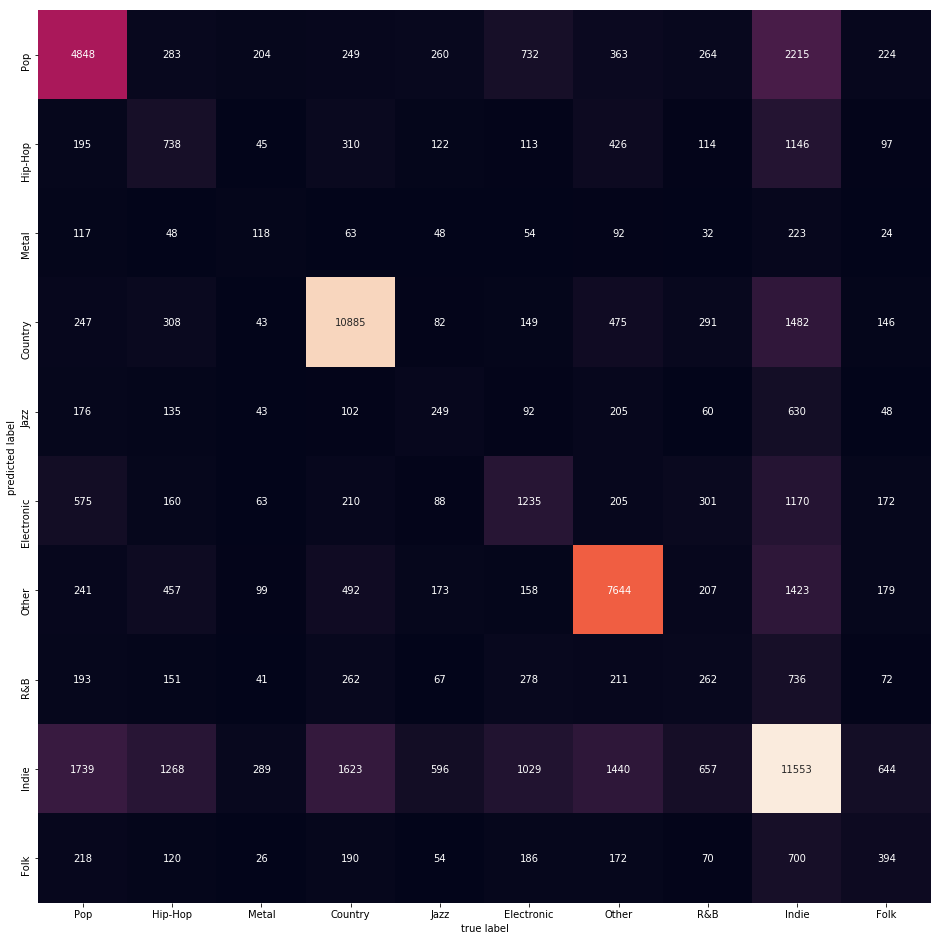

In [69]:
get_stats(pipeline, X_train, X_test, y_train, y_test, genres)

In [70]:
def try_multinomial_NB():
    pipeline = Pipeline(
        [('features', CountVectorizer()),
         ('clf', MultinomialNB(alpha=0.001))])

    prediction = cross_val_score(pipeline, X_train.lyrics, y_train.genre, cv=3, n_jobs=-1)
    pipeline.fit(X_train.lyrics, y_train.genre)
    
    print(prediction)
    
    return pipeline, prediction

pipeline, prediction = try_multinomial_NB()
result["multinomial_nb"] = prediction

[0.58101228 0.57994951 0.58359014]


Success rate: 0.5855318409545046
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[('verse', 109103), ('gun', 44957), ('shots', 91008), ('she', 90290), ('like', 59117), ('the', 101635), ('realest', 82067), ('shit', 90707), ('ever', 35066), ('wrote', 113759), ('drug', 31337), ('addiction', 2249), ('for', 39296), ('my', 67677), ('pain', 73400)]
Pop recall: 0.5756228798689905
Pop precision: 0.5519291161956034
Pop fscore: 0.5635270541082164
Pop support: 8549

Hip-Hop recall: 0.15130861504907306
Hip-Hop precision: 0.3004872766648619
Hip-Hop fscore: 0.20126926563916592
Hip-Hop support: 3668

Metal recall: 0.1791967044284243
Metal precision: 0.21323529411764705
Metal fscor

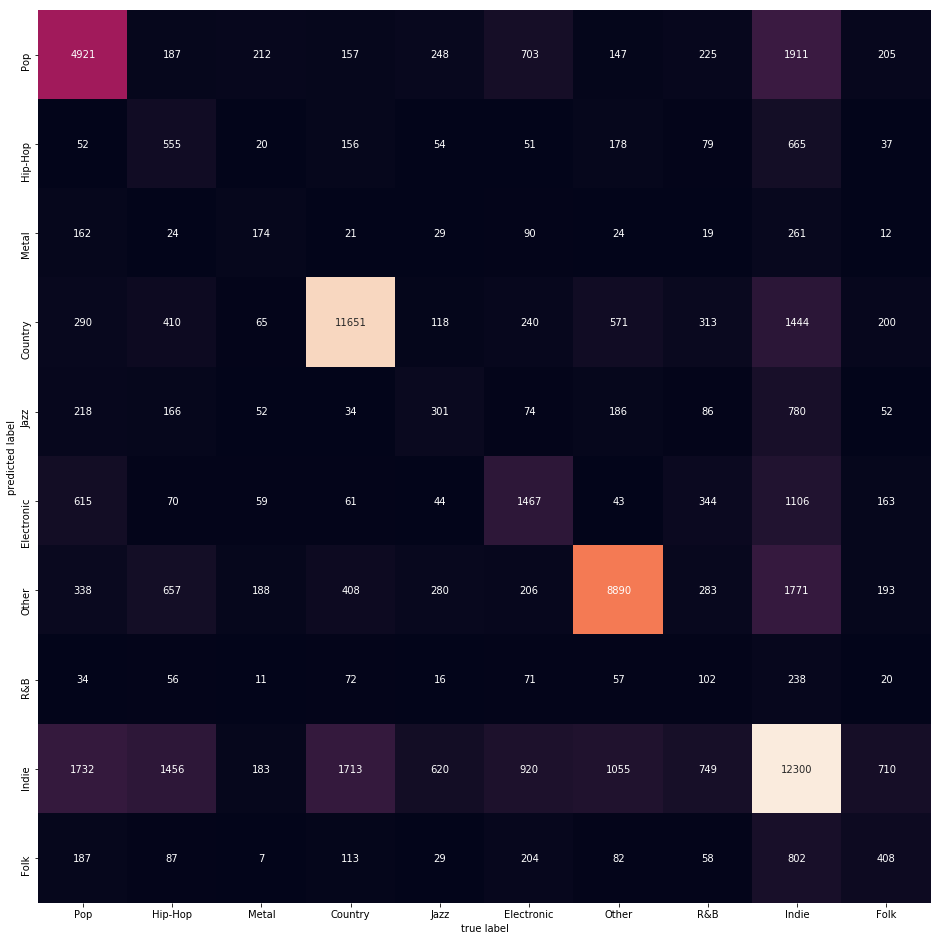

In [71]:
get_stats(pipeline, X_train, X_test, y_train, y_test, genres)

In [72]:
def try_logistic_regression():
    pipeline = Pipeline(
    [('features', CountVectorizer()),
     ('clf', LogisticRegression())])

    prediction = cross_val_score(pipeline, X_train.lyrics, y_train.genre, cv=3, n_jobs=-1)
    pipeline.fit(X_train.lyrics, y_train.genre)
    
    print(prediction)
    
    return pipeline, prediction
    
pipeline, prediction = try_logistic_regression()
result["logistic_regression"] = prediction

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.60595559 0.608318   0.60678822]


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Success rate: 0.6258434450204164
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[('verse', 109103), ('gun', 44957), ('shots', 91008), ('she', 90290), ('like', 59117), ('the', 101635), ('realest', 82067), ('shit', 90707), ('ever', 35066), ('wrote', 113759), ('drug', 31337), ('addiction', 2249), ('for', 39296), ('my', 67677), ('pain', 73400)]
Pop recall: 0.5980816469762545
Pop precision: 0.5580659244706396
Pop fscore: 0.577381288464796
Pop support: 8549

Hip-Hop recall: 0.09351145038167939
Hip-Hop precision: 0.33726647000983284
Hip-Hop fscore: 0.1464247598719317
Hip-Hop support: 3668

Metal recall: 0.121524201853759
Metal precision: 0.2027491408934708
Metal fscore: 

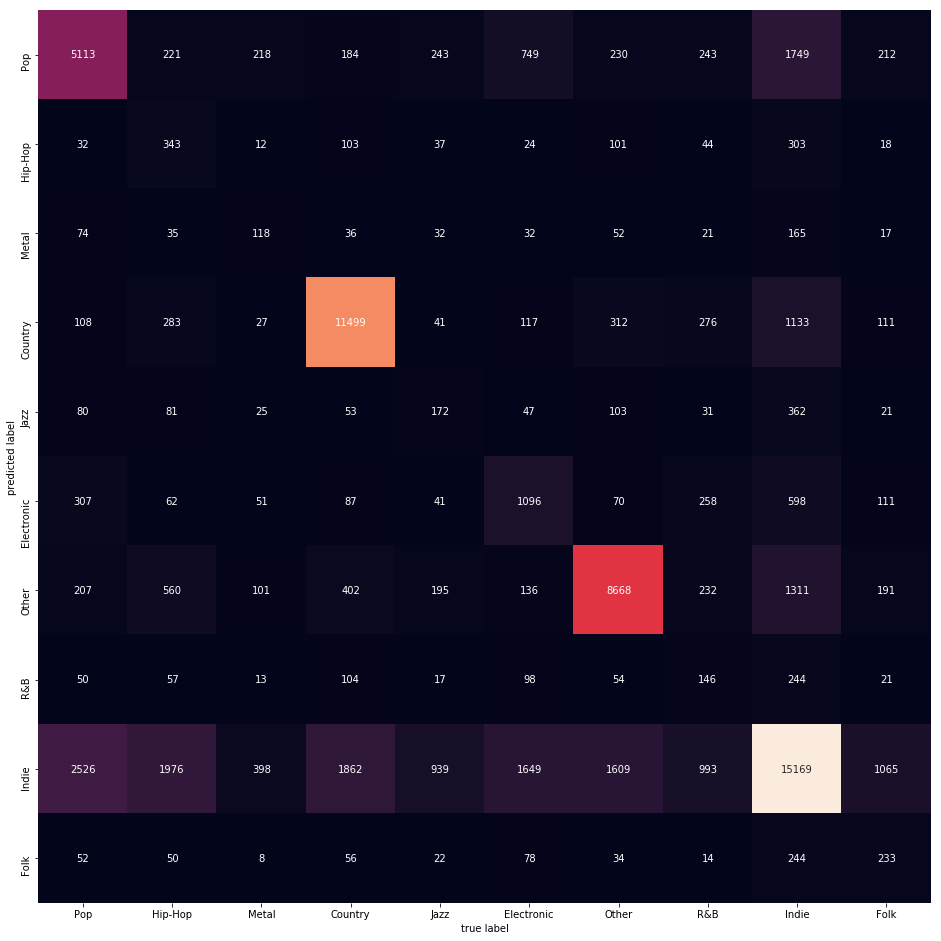

In [73]:
get_stats(pipeline, X_train, X_test, y_train, y_test, genres)

Изглежда, че логистичната регресия се представя най-добре за сега. <br>
Този резултат не е много добър нека се опитаме да го подобрим. Нека добавим нови feature-и и да видим дали ще подобрим модела. Понеже добавянето на нови данни отнема много време, ще ги запишем във файл, който да зареждаме надолу.

In [74]:
def get_stopwords():
    #nltk.download('stopwords')
    #nltk.download('wordnet')
    stopwords = nltk.corpus.stopwords.words('english')
    print(len(stopwords))
    print(stopwords)
    return stopwords

stopwords = get_stopwords()

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [75]:
def add_morefeatures(dataset):
    print(dataset.shape)
    
    dataset = dataset.copy()

    dataset['words'] = dataset.lyrics.apply(lambda s: len(str(s).split()))
    dataset['unique_words'] = dataset.lyrics.apply(lambda s: len(set(str(s).split())))
    dataset['symbols'] = dataset.lyrics.str.len()
    dataset['unique_symbols'] = dataset.lyrics.apply(lambda s: len(set(str(s))))
    dataset['capital_letters'] = dataset.lyrics.apply(lambda s: sum([str.isupper(c) for c in str(s)]))
    dataset['only_capital_letter_words'] = dataset.lyrics.apply(lambda s: sum([str.isupper(w) for w in str(s).split()]))
    dataset['average_word_length'] = dataset.lyrics.apply(lambda s: np.mean([len(w) for w in str(s).split()]))
    dataset["punctuation"] = dataset.lyrics.apply(lambda s: sum([c in string.punctuation for c in str(s)]) )
    dataset['stop_words'] = dataset.lyrics.apply(lambda s: sum(w in stopwords for w in str(s).split()))

    dataset.to_csv("reduced_morefeatures.csv")
    dataset.head()
    
    return dataset
    
#explore = add_morefeatures(dataset)
#print(explore.shape)

In [76]:
def load_explore():
    explore = pd.read_csv("reduced_morefeatures.csv")
    explore = explore.drop("Unnamed: 0", axis=1)
    print(explore.shape)
    explore.info()
    return explore
explore = load_explore()

(104639, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104639 entries, 0 to 104638
Data columns (total 11 columns):
genre                        104639 non-null object
lyrics                       104639 non-null object
words                        104639 non-null int64
unique_words                 104639 non-null int64
symbols                      104639 non-null int64
unique_symbols               104639 non-null int64
capital_letters              104639 non-null int64
only_capital_letter_words    104639 non-null int64
average_word_length          104639 non-null float64
punctuation                  104639 non-null int64
stop_words                   104639 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 8.8+ MB


['words', 'only_capital_letter_words', 'punctuation', 'unique_symbols', 'symbols', 'average_word_length', 'unique_words', 'stop_words', 'capital_letters']


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x576 with 0 Axes>

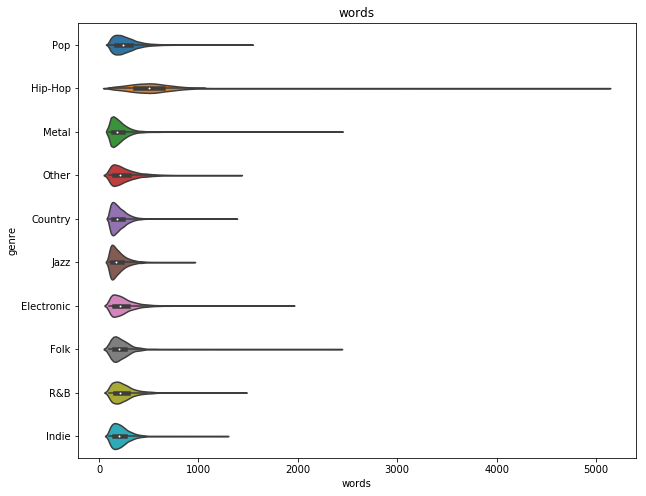

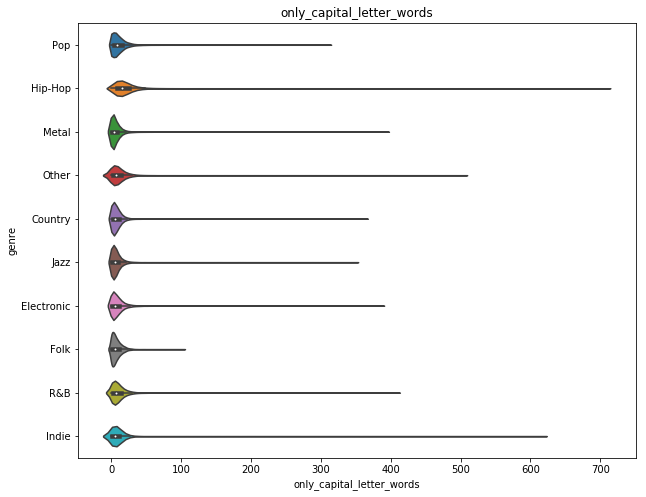

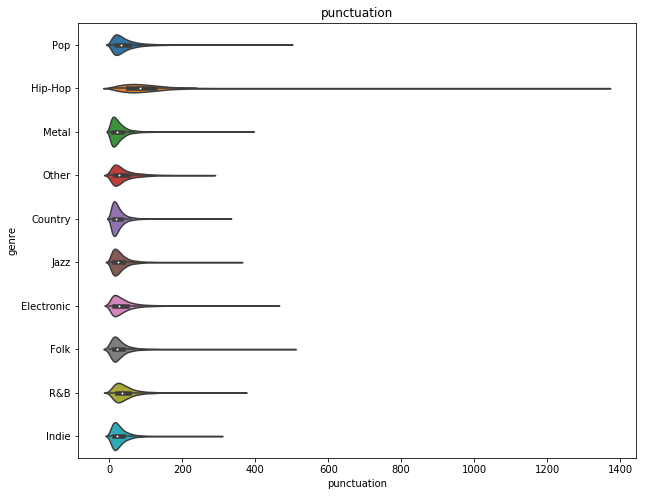

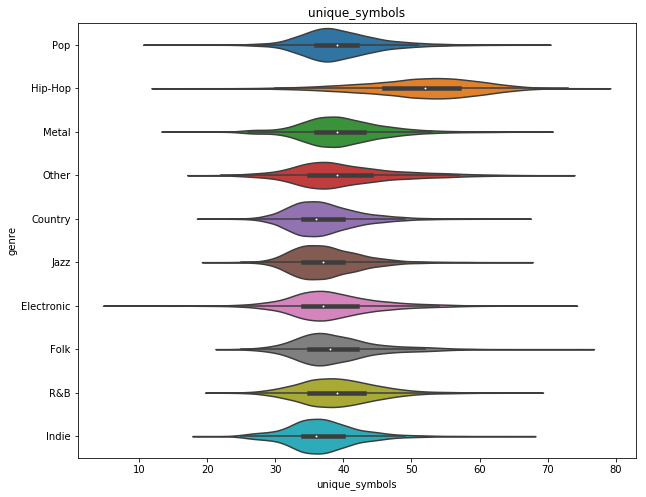

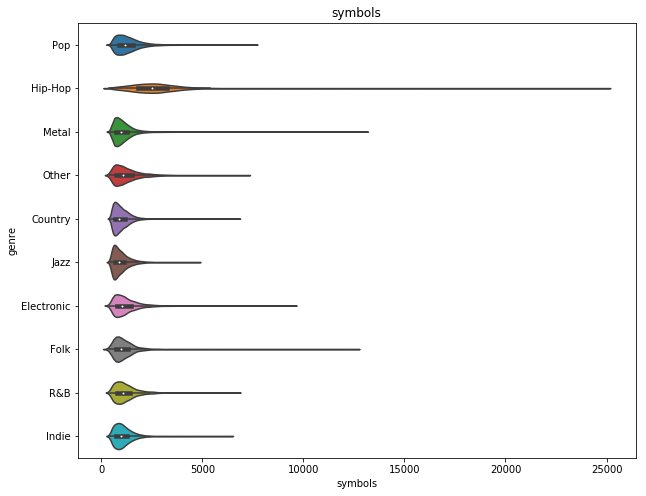

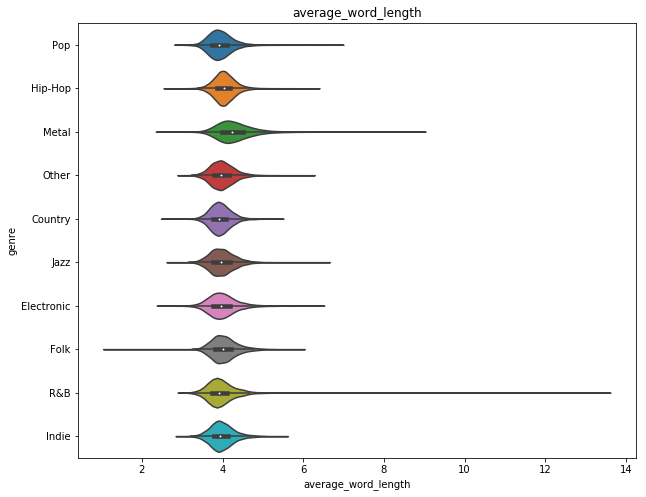

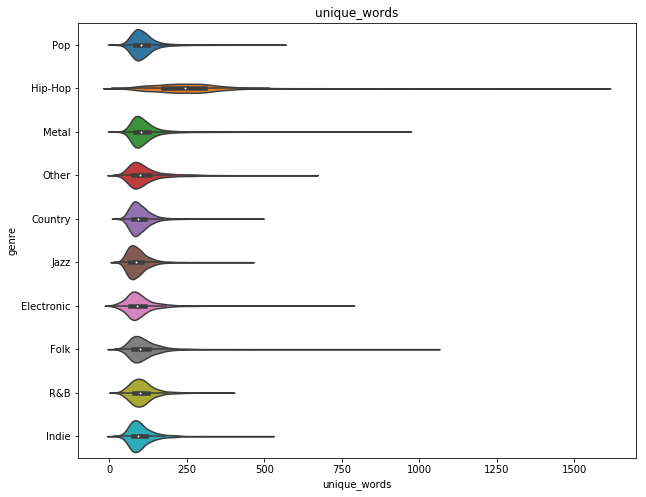

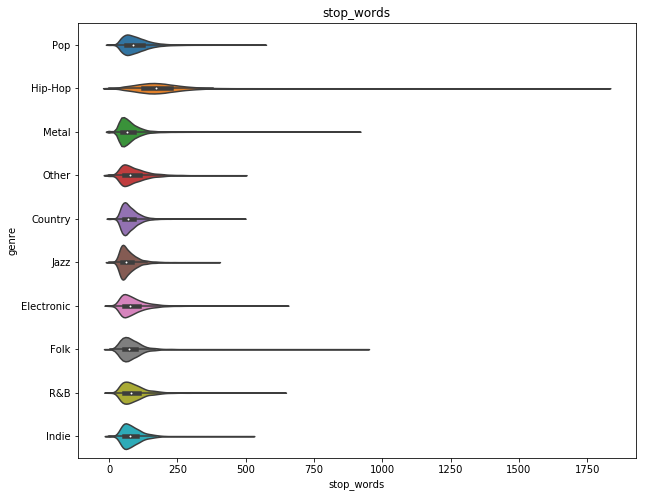

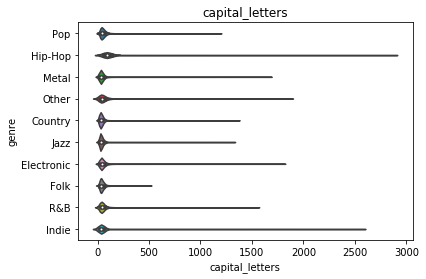

In [77]:
features = list(set(explore.columns) - {"lyrics", "genre"})
print(features)

for feature in features:
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.figure()
    sns.violinplot(x=feature, y="genre", data=explore)
    plt.title(feature);

Забелязваме, че хип-хоп песните се отличават от другите групи по брой stop-words, уникални думи, брой думи и уникални символи. Тоест те са най-различаващатата се група, а останалите са доста подобни една на друга.

Добре нека пробваме, други класификатори с новите данни.

['words', 'only_capital_letter_words', 'punctuation', 'unique_symbols', 'symbols', 'average_word_length', 'unique_words', 'stop_words', 'capital_letters']
(104639, 9)
(104639, 1)
######
(70108, 9)
(34531, 9)
(70108, 1)
(34531, 1)
[0.48752834 0.48951647 0.49265996]


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


words = 0.10553935412643245
only_capital_letter_words = 0.07739126168972232
punctuation = 0.10055890228035311
unique_symbols = 0.09968755954165845
symbols = 0.1300572079120235
average_word_length = 0.1321881128871326
unique_words = 0.1509283094499749
stop_words = 0.10189374537382109
capital_letters = 0.10175554673888157


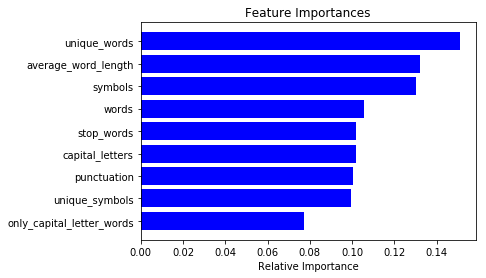

In [78]:
def feature_importance(forest, X_train):
    for name, importance in zip(X_train.columns, forest.feature_importances_):
        print(name, "=", importance)
        
    features = X_train.columns
    importances = forest.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

def try_explore_random_forest(explore):
    
    features = list(set(explore.columns) - {"lyrics", "genre"})
    print(features)
    y = explore["genre"]
    X = explore[features]
    y = pd.DataFrame(y)
    print(X.shape)
    print(y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        stratify=y, 
                                                        random_state=42, 
                                                        test_size=0.33, shuffle=True)
    
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
        
    print("######")
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    clf = RandomForestClassifier()
    prediction = cross_val_score(clf, X_train[features], y_train, cv=3, n_jobs=-1)
    print(prediction)
    
    clf.fit(X_train[features], y_train)
    feature_importance(clf, X_train)
    
    return prediction

prediction = try_explore_random_forest(explore)
result["random_forest_explore"] = prediction

In [79]:
def try_explore_LSVC(explore):
    
    features = list(set(explore.columns) - {"lyrics", "genre"})
    print(features)
    y = explore["genre"]
    X = explore[features]
    y = pd.DataFrame(y)
    print(X.shape)
    print(y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        stratify=y, 
                                                        random_state=42, 
                                                        test_size=0.33, shuffle=True)
    
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
        
    print("######")
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    clf = LinearSVC()
    prediction = cross_val_score(clf, X_train[features], y_train, cv=3, n_jobs=-1)
    
    print(prediction)
    
    return prediction

prediction = try_explore_LSVC(explore)
result["linear_svc_explore"] = prediction

['words', 'only_capital_letter_words', 'punctuation', 'unique_symbols', 'symbols', 'average_word_length', 'unique_words', 'stop_words', 'capital_letters']
(104639, 9)
(104639, 1)
######
(70108, 9)
(34531, 9)
(70108, 1)
(34531, 1)
[0.3207975  0.3614463  0.18472074]


In [80]:
def try_explore_logistic_regression(explore):
    
    features = list(set(explore.columns) - {"lyrics", "genre"})
    print(features)
    y = explore["genre"]
    X = explore[features]
    y = pd.DataFrame(y)
    print(X.shape)
    print(y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        stratify=y, 
                                                        random_state=42, 
                                                        test_size=0.33, shuffle=True)
    
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
        
    print("######")
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    clf = LogisticRegression()
    prediction = cross_val_score(clf, X_train[features], y_train, cv=3, n_jobs=-1)
    
    print(prediction)
    
    return prediction

prediction = try_explore_logistic_regression(explore)
result["logistic_regression_explore"] = prediction

['words', 'only_capital_letter_words', 'punctuation', 'unique_symbols', 'symbols', 'average_word_length', 'unique_words', 'stop_words', 'capital_letters']
(104639, 9)
(104639, 1)
######
(70108, 9)
(34531, 9)
(70108, 1)
(34531, 1)
[0.48872631 0.49028669 0.4911192 ]


In [81]:
def try_explore_multinomial_nb(explore):
    
    features = list(set(explore.columns) - {"lyrics", "genre"})
    print(features)
    y = explore["genre"]
    X = explore[features]
    y = pd.DataFrame(y)
    print(X.shape)
    print(y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        stratify=y, 
                                                        random_state=42, 
                                                        test_size=0.33, shuffle=True)
    
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
        
    print("######")
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    clf = MultinomialNB()
    prediction = cross_val_score(MultinomialNB(), X_train[features], y_train, cv=3, n_jobs=-1)
    
    print(prediction)
    
    return prediction

prediction = try_explore_multinomial_nb(explore)
result["multinomial_nb_explore"] = prediction

['words', 'only_capital_letter_words', 'punctuation', 'unique_symbols', 'symbols', 'average_word_length', 'unique_words', 'stop_words', 'capital_letters']
(104639, 9)
(104639, 1)
######
(70108, 9)
(34531, 9)
(70108, 1)
(34531, 1)
[0.37945493 0.3826273  0.3818532 ]


Нямаме подобрение, затова нека се върнем назад и погледнем най-често срещаните думи за всеки жанр:

Забелязваме, че ще е добре да ползваме stemming/lemmatization за да махнем ненужните окончания на думите и да оставим само корена.

In [82]:
def calculate_data(data, genres):
    vectorizers = []
    for genre in genres:
        cv = CountVectorizer(stop_words='english')
        corpus = data[data.genre == genre].lyrics.values
        cv.fit(corpus)
        bag_of_words = cv.transform(corpus)
        vectorizers.append((genre, cv, bag_of_words))
        
    for pair in vectorizers:
            genre = pair[0]
            print(genre)
            
            cv = pair[1]
            bag_of_words = pair[2]
            sum_words = pair[2].sum(axis=0)
            words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
            words_freq = (sorted(words_freq, key = lambda x: x[1], reverse=True))[0:10]
            print(words_freq)

calculate_data(explore, genres)

Pop
[('love', 79655), ('know', 59630), ('don', 59354), ('oh', 57968), ('just', 49444), ('like', 48790), ('ll', 41451), ('baby', 38368), ('let', 34613), ('got', 34518)]
Hip-Hop
[('like', 95648), ('got', 65321), ('don', 61629), ('know', 60175), ('just', 48244), ('ain', 42258), ('nigga', 42194), ('cause', 38104), ('shit', 35951), ('let', 31580)]
Metal
[('life', 13034), ('time', 12225), ('ll', 12137), ('don', 11852), ('like', 11102), ('just', 10252), ('know', 10097), ('ve', 9288), ('world', 7955), ('away', 7858)]
Country
[('love', 19486), ('just', 15597), ('ll', 14767), ('don', 13361), ('know', 12395), ('like', 12295), ('ve', 11318), ('got', 9332), ('time', 9213), ('oh', 8830)]
Jazz
[('love', 12709), ('don', 6508), ('know', 6479), ('ll', 6449), ('just', 6320), ('oh', 5715), ('like', 5209), ('got', 4979), ('baby', 4779), ('ve', 4172)]
Electronic
[('love', 9953), ('don', 8495), ('know', 7518), ('like', 6978), ('just', 6890), ('oh', 6674), ('ll', 5394), ('come', 4947), ('let', 4878), ('want',

Нека направим stemming и lemmatization. Отнема много време затова отново ще го запишем във файл.

In [83]:
lemmatizer = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemmatizer.lemmatize(w) for w in analyzer(doc))

In [84]:
def stemmify(data):
    stem = PorterStemmer()
    data['stem'] = data.lyrics.apply(lambda t: " ".join([stem.stem(w) for w in t.split()]))
    return data

#explore = stemmify(explore)
#explore.to_csv("reduced_stemmed.csv")

In [85]:
def load_stemmed():
    dataset = pd.read_csv("reduced_stemmed.csv")
    dataset = dataset[~dataset.genre.str.contains("Rock")]
    dataset = dataset.drop("Unnamed: 0", axis=1)
    return dataset
    
explore = load_stemmed()
explore[['stem', 'lyrics']].head()

,stem,lyrics
0,"Oh baby, how you doing? you know i'm gonna cut...","Oh baby, how you doing? You know I'm gonna cut..."
1,"playin' everyth so easy, it' like you seem so ...","playin' everything so easy, it's like you seem..."
2,If you search for tender It isn't hard to find...,If you search For tenderness It isn't hard to ...
3,"Oh oh oh I, oh oh oh I [vers 1:] If I wrote a ...","Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,"parti the people, the peopl the parti it' pop ...","Party the people, the people the party it's po..."


In [86]:
def calculate_stemmed_data(data, genres):
    vectorizers = []
    for genre in genres:
        cv = LemmaCountVectorizer(stop_words='english')
        corpus = data[data.genre == genre].stem.values
        cv.fit(corpus)
        bag_of_words = cv.transform(corpus)
        vectorizers.append((genre, cv, bag_of_words))
        
    for pair in vectorizers:
            genre = pair[0]
            print(genre)
            
            cv = pair[1]
            bag_of_words = pair[2]
            sum_words = pair[2].sum(axis=0)
            words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
            words_freq = (sorted(words_freq, key = lambda x: x[1], reverse=True))[0:10]
            print(words_freq)

calculate_stemmed_data(explore, genres)

Pop
[('love', 86508), ('know', 63578), ('don', 59357), ('oh', 57972), ('just', 49445), ('like', 49423), ('thi', 42647), ('ll', 40816), ('want', 37096), ('let', 36629)]
Hip-Hop
[('like', 96317), ('nigga', 71809), ('got', 66058), ('know', 62417), ('don', 61667), ('thi', 57703), ('just', 48245), ('ain', 42258), ('caus', 37941), ('shit', 36424)]
Metal
[('thi', 23150), ('time', 13682), ('life', 13222), ('ll', 12007), ('don', 11859), ('like', 11172), ('know', 11054), ('just', 10252), ('come', 10187), ('wa', 8748)]
Country
[('love', 22735), ('just', 15597), ('ll', 14401), ('know', 14029), ('don', 13363), ('like', 12636), ('wa', 12168), ('time', 10677), ('thi', 10607), ('got', 9333)]
Jazz
[('love', 14386), ('know', 7131), ('don', 6508), ('just', 6320), ('ll', 6222), ('oh', 5715), ('like', 5300), ('got', 4983), ('come', 4598), ('thi', 4408)]
Electronic
[('love', 10745), ('don', 8498), ('know', 7842), ('thi', 7375), ('like', 7040), ('just', 6892), ('oh', 6675), ('feel', 6354), ('come', 6263), ('

Няма особено голяма разлика между думите stemmed+lemmatized и нормално.

In [87]:
def get_stats_stem(data, pipeline, genres):
    prediction = cross_val_predict(pipeline, data.lyrics, data.genre, cv=3, n_jobs=-1)
    plot_confusion_matrix(data.genre, prediction, genres)

    precision, recall, fscore, support = precision_recall_fscore_support(data.genre, prediction)
    for n, genre in enumerate(genres):
        print(str(genre) + ' recall: {}'.format(recall[n]))
        print(str(genre) + ' precision: {}'.format(precision[n]))
        print(str(genre) + ' fscore: {}'.format(fscore[n]))
        print(str(genre) + ' support: {}'.format(support[n]))
        print()

In [88]:
def try_stemming_logistic_regression(data):
    train, test = train_test_split(data, test_size=0.33, random_state=42)
    
    pipeline = Pipeline(
    [('features', CountVectorizer()),
     ('clf', LogisticRegression())])

    prediction = cross_val_score(pipeline, train.stem, train.genre, cv=3, n_jobs=-1)
    pipeline.fit(data.stem, explore.genre)
    
    print(prediction)
    
    return pipeline, prediction
    
pipeline, prediction = try_stemming_logistic_regression(explore)
result["logistic_regression_explore_stemmed"] = prediction

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.60634065 0.60789012 0.61123951]


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pop recall: 0.5974730641035578
Pop precision: 0.5592396430385257
Pop fscore: 0.5777244790885924
Pop support: 12901

Hip-Hop recall: 0.03660295708618824
Hip-Hop precision: 0.1614956245027844
Hip-Hop fscore: 0.05967955313832132
Hip-Hop support: 5546

Metal recall: 0.07916102841677942
Metal precision: 0.1517509727626459
Metal fscore: 0.10404624277456645
Metal support: 1478

Country recall: 0.775720068866037
Country precision: 0.8056736903150976
Country fscore: 0.7904131996301826
Country support: 21491

Jazz recall: 0.056765163297045104
Jazz precision: 0.12016460905349795
Jazz fscore: 0.07710588856614735
Jazz support: 2572

Electronic recall: 0.27040644944575076
Electronic precision: 0.3990086741016109
Electronic fscore: 0.322354590049054
Electronic support: 5954

Other recall: 0.773131301079759
Other precision: 0.7143250840544563
Other fscore: 0.7425657480089384
Other support: 16763

R&B recall: 0.03827460510328068
R&B precision: 0.13361611876988336
R&B fscore: 0.05950413223140495
R&B sup

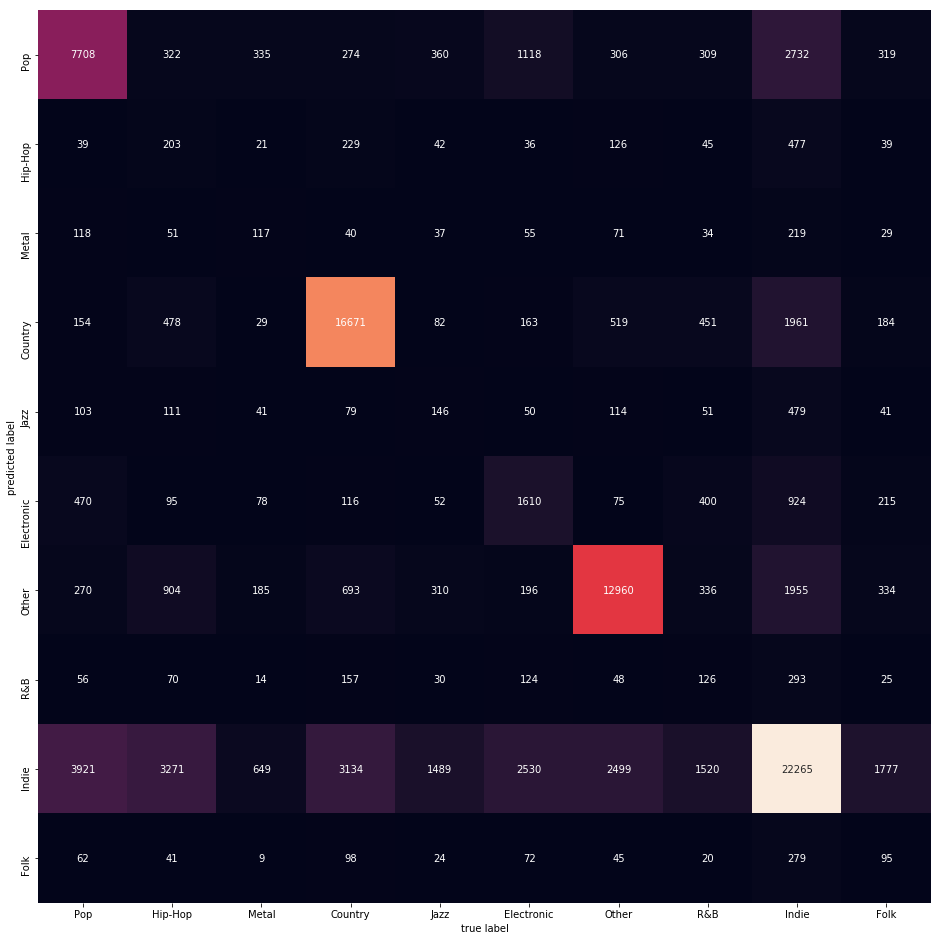

In [89]:
get_stats_stem(explore, pipeline, genres)

In [90]:
def try_stemming_multinomial_nb(data):
    train, test = train_test_split(data, test_size=0.33, random_state=42)
    
    pipeline = Pipeline(
    [('features', CountVectorizer()),
     ('clf', MultinomialNB())])

    prediction = cross_val_score(pipeline, train.stem, train.genre, cv=3, n_jobs=-1)
    pipeline.fit(data.stem, explore.genre)
    
    print(prediction)
    
    return pipeline, prediction
    
pipeline, prediction = try_stemming_multinomial_nb(explore)
result["multinomial_nb_explore_stemmed"] = prediction

[0.59085269 0.59017586 0.59266393]


Pop recall: 0.56724284939152
Pop precision: 0.4858261966407754
Pop fscore: 0.5233872121298813
Pop support: 12901

Hip-Hop recall: 0.03371799495131626
Hip-Hop precision: 0.1890798786653185
Hip-Hop fscore: 0.057230298393267015
Hip-Hop support: 5546

Metal recall: 0.04262516914749662
Metal precision: 0.36416184971098264
Metal fscore: 0.07631738340399759
Metal support: 1478

Country recall: 0.765250570006049
Country precision: 0.7825466311381805
Country fscore: 0.7738019620297835
Country support: 21491

Jazz recall: 0.0019440124416796269
Jazz precision: 0.05813953488372093
Jazz fscore: 0.0037622272385252073
Jazz support: 2572

Electronic recall: 0.1891165602955996
Electronic precision: 0.4345812427634118
Electronic fscore: 0.26354593329432413
Electronic support: 5954

Other recall: 0.7773071645886774
Other precision: 0.6609851367118146
Other fscore: 0.7144423730672222
Other support: 16763

R&B recall: 0.004556500607533414
R&B precision: 0.11278195488721804
R&B fscore: 0.00875912408759124
R

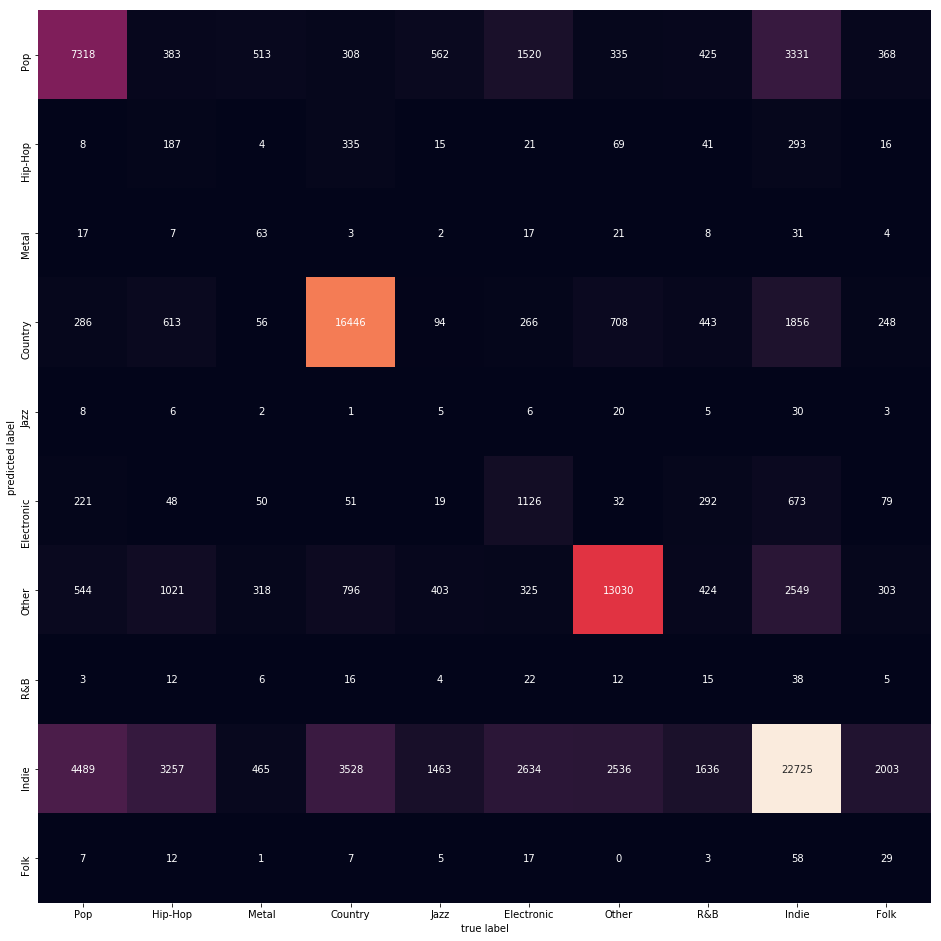

In [91]:
get_stats_stem(explore, pipeline, genres)

<h1>Param search:</h1>

Нека потърсим по-оптимални параметри на CountVectorizer, TfidfVectorizer

Ще използваме RandomizedSearchCV, за да намерим оптимални hyperparams. Ще използваме scoring="neg_log_loss", за да накажем сигурните+грешни prediction-и. 

In [119]:
params_count_word = {"features__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

In [94]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [106]:
def count_logreg_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', CountVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss', n_iter=20, cv=3, n_jobs=4)

    random_search.fit(X_train.lyrics, y_train.genre)
    report(random_search.cv_results_)
    
count_logreg_search()

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model with rank: 1
Mean validation score: -1.260 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 3, 'features__max_df': 0.7, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 0.01}

Model with rank: 2
Mean validation score: -1.261 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 0.8, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 0.01}

Model with rank: 3
Mean validation score: -1.368 (std: 0.004)
Parameters: {'features__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'w

In [109]:
def tfidf_logreg_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(X_train.lyrics, y_train.genre)
    report(random_search.cv_results_)

tfidf_logreg_search()

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model with rank: 1
Mean validation score: -1.172 (std: 0.001)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 3, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 2
Mean validation score: -1.185 (std: 0.005)
Parameters: {'features__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'a

In [110]:
def tfidf_mnb_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(X_train.lyrics, y_train.genre)
    report(random_search.cv_results_)

tfidf_mnb_search()

Model with rank: 1
Mean validation score: -1.304 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 10, 'features__max_df': 0.9, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 2
Mean validation score: -1.384 (std: 0.002)
Parameters: {'features__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'b

Потърсихме параметри и в крайна сметка:

In [92]:
'''
Model with rank: 1
Mean validation score: -1.304 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 10, 'features__max_df': 0.9, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.1}
'''
def try_final_mnb_tfidf():
    
    pipeline = Pipeline([
        ('features', TfidfVectorizer(stop_words=None, ngram_range=(1,2), min_df=10, max_df=0.9, lowercase=False, analyzer="word")),
        ('clf', MultinomialNB(alpha=0.1))])
        
    prediction = cross_val_score(pipeline, X_train.lyrics, y_train.genre, cv=3, n_jobs=-1)
    
    print(prediction)
    
    return prediction
    
prediction = try_final_mnb_tfidf()
result["multinomial_nb_params"] = prediction

[0.60877936 0.6104574  0.60999829]


In [93]:
'''
Model with rank: 1
Mean validation score: -1.260 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 3, 'features__max_df': 0.7, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 0.01}
'''
def try_final_logistic_regression_cv():
    
    pipeline = Pipeline([
        ('features', CountVectorizer(stop_words=None, ngram_range=(1,2), min_df=3, max_df=0.7, lowercase=True, analyzer="word")),
        ('clf', LogisticRegression(class_weight=None, C=0.01))])

    prediction = cross_val_score(pipeline, X_train.lyrics, y_train.genre, cv=3, n_jobs=-1)
    
    print(prediction)
    
    return prediction
    
prediction = try_final_logistic_regression_cv()
result["logistic_regression_params"] = prediction

[0.63308091 0.63839801 0.63546482]


In [96]:
'''
Model with rank: 1
Mean validation score: -1.172 (std: 0.001)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 3, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}
'''
def try_final_logistic_regression_tfidf():
    
    pipeline = Pipeline([
        ('features', TfidfVectorizer(stop_words=None, ngram_range=(1,2), min_df=3, max_df=0.9, lowercase=True, analyzer="word")),
        ('clf', LogisticRegression(class_weight=None, C=10))])

    prediction = cross_val_score(pipeline, X_train.lyrics, y_train.genre, cv=3, n_jobs=-1)
    
    print(prediction)
    
    return pipeline, prediction
    
pipeline, prediction = try_final_logistic_regression_tfidf()
result["logistic_regression_params"] = prediction

[0.64347752 0.64802533 0.64607944]


Това е най-добрият ни резултат до сега. Оставаме с него.

In [110]:
def test(X_train, y_train):
    pipeline = Pipeline([
    ('features', TfidfVectorizer(stop_words=None, ngram_range=(1,2), lowercase=True, analyzer="word")),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(class_weight=None, C=10))])

    pipeline.fit(X_train.lyrics, y_train.genre)
    
    return pipeline

pipeline = test(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [119]:
little_test = [
    #hip-hip
    "Gucci Gang, ooh, yeah, Lil Pump, yeah, Gucci Gang, ooh Gucci gang, Gucci gang, Gucci gang, Gucci gang Gucci gang, Gucci gang, Gucci gang (Gucci gang!) Spend ten racks on a new chain My bitch love do cocaine, ooh I fuck a bitch, I forgot her name I can't buy a bitch no wedding ring",
    #metal   
    "Here our soldiers stand From all around the world Waiting in a line To hear the battle cry All are gathered here Victory is near The sound will fill the hall Bringing power to us all We alone are fighting For metal that is true We only ride to live the fight We're here for all of you Now swear the blood upon your steel We'll never try Stand and fight together Beneath the metal sky",
    #pop
    "Hey Havana, ooh na-na (ay) Half of my heart is in Havana, ooh-na-na (ay, ay) He took me back to East Atlanta, na-na-na Oh, but my heart is in Havana (ay) There's somethin' 'bout his manners (uh huh) Havana, ooh na-na (uh)",
    #r&b
    "It might seem crazy what I'm 'bout to say Sunshine she's here, you can take a break I'm a hot air balloon that could go to space With the air, like I don't care, baby, by the way [Chorus] (Because I'm happy) Clap along if you feel like a room without a roof (Because I'm happy) Clap along if you feel like happiness is the truth",
    #:D
    "I wonder what genre a song about a project for song genre prediction for a machine learning course at FMI will have.",
    #:D
    '''
    You’ve got some data, and need
    to find a rule that can predict,
    you want a theta,
    that works for any instance that you pick.
    It’s Bellman’s curse,
    the classifier needs to fit the labels.
    You start a search,
    but training error that you minimize,
    won’t generalize!

    You overfit it,
    spit it out,
    mistakes that you shouldn’t make - evaluate the testing site.
    You overfit it,
    quit it now,
    you will need another way or you’ll regret it - get it, no doubt!

    Boosting, bagging, weight decay.
    A gaping margin saves your day.
    But what a chilling plot this is,
    To find the right hypotesis.
    You’ve let down your guard one small bit.
    Oh no, it seems you’ve underfit.

    Without a strong and helpful prior.
    You’re doomed to chase a lone outlier.
    The noise runs through your neural net,
    Bewildering your dataset.
    ''']
for song in little_test:
    song.replace("\n", " ")

pipeline.predict(little_test)

array(['Hip-Hop', 'Metal', 'Pop', 'Pop', 'Metal', 'Metal'], dtype=object)

<h1>Заключение</h1>

In [95]:
print(result)

{'linear_svc': array([0.54729816, 0.53164178, 0.547937  ]), 'multinomial_nb': array([0.58101228, 0.57994951, 0.58359014]), 'logistic_regression': array([0.60595559, 0.608318  , 0.60678822]), 'random_forest_explore': array([0.48752834, 0.48951647, 0.49265996]), 'linear_svc_explore': array([0.3207975 , 0.3614463 , 0.18472074]), 'logistic_regression_explore': array([0.48872631, 0.49028669, 0.4911192 ]), 'multinomial_nb_explore': array([0.37945493, 0.3826273 , 0.3818532 ]), 'logistic_regression_explore_stemmed': array([0.60634065, 0.60789012, 0.61123951]), 'multinomial_nb_explore_stemmed': array([0.59085269, 0.59017586, 0.59266393]), 'multinomial_nb_params': array([0.60877936, 0.6104574 , 0.60999829]), 'logistic_regression_params': array([0.64347752, 0.64802533, 0.64607944])}


Следващи стъпки: <br>

1. Нормализиране на данните за по-добър модел <br>
2. Използване на няколко класификатора заедно <br>
3. Невронни мрежи за Word embedding. <br>
4. използване на feature-и получени от използването на LDA.